In [1]:
import numpy as np
import pandas as pd
import loompy
import velocyto as vcy
import matplotlib.pyplot as plt
import matplotlib as mpl
import copy
import igraph as ig
import louvain
import umap
import networkx
import community
import pandas as pd
import scanpy as sc
import seaborn as sns
from collections import Counter
from sklearn.neighbors import NearestNeighbors

/opt/anaconda3/lib/python3.7/site-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 11000. The TBB threading layer is disabled.
  warnings.warn(problem)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
plt.rcParams["pdf.fonttype"] = 42

In [3]:
from sklearn.svm import SVR
import numpy as np
import matplotlib.pyplot as plt


def filter_cv_vs_mean(S: np.ndarray, N: int, svr_gamma: float=None, plot: bool=True, min_expr_cells: int=2,
                      max_expr_avg: float=20, min_expr_avg: float=0) -> np.ndarray:
    muS = S.mean(1)
    detected_bool = ((S > 0).sum(1) > min_expr_cells) & (muS < max_expr_avg) & (muS > min_expr_avg)
    
    Sf = S[detected_bool, :]
    mu = Sf.mean(1)
    sigma = Sf.std(1, ddof=1)

    cv = sigma / mu
    log_m = np.log2(mu)
    log_cv = np.log2(cv)
    
    if svr_gamma is None:
        svr_gamma = 150. / len(mu)
    
    svr = SVR(gamma=svr_gamma)
    svr.fit(log_m[:, None], log_cv)
    fitted_fun = svr.predict
    ff = fitted_fun(log_m[:, None])
    score = log_cv - ff

    xnew = np.linspace(np.min(log_m), np.max(log_m))
    ynew = svr.predict(xnew[:, None])

    nth_score = np.sort(score)[::-1][N]
    
    if plot:
        plt.scatter(log_m[score > nth_score], log_cv[score > nth_score], s=3, alpha=0.4, c="tab:red")
        plt.scatter(log_m[score <= nth_score], log_cv[score <= nth_score], s=3, alpha=0.4, c="tab:blue")
        mu_linspace = np.linspace(np.min(log_m), np.max(log_m))
        plt.plot(mu_linspace, fitted_fun(mu_linspace[:, None]), c="k")
        plt.xlabel("log2 mean S")
        plt.ylabel("log2 CV S")
    
    cv_mean_score = np.zeros(detected_bool.shape)
    cv_mean_score[~detected_bool] = np.min(score) - 1e-16
    cv_mean_score[detected_bool] = score
    cv_mean_selected = cv_mean_score >= nth_score
    return cv_mean_selected

In [4]:
from miscalg import *

In [5]:
vlm = vcy.VelocytoLoom("hESC-RPE_invitro_differentiation.loom")

## Look at anticorrelated genes to retinal progenitor signature

In [6]:
D30_filt = copy.deepcopy(vlm)
D30_filt.filter_cells(bool_array=np.array([i in ['D30:CrNeCr',
 'D30:RetProg3'] for i in D30_filt.ca["CellTypeCategory2"]]))

In [7]:
D30_filt._normalize_S(relative_size=D30_filt.initial_cell_size,
                      target_size=np.mean(D30_filt.initial_cell_size))

D30_filt._normalize_U(relative_size=D30_filt.initial_Ucell_size,
                      target_size=np.mean(D30_filt.initial_Ucell_size))

D30_filt.perform_PCA()

df30 = pd.DataFrame(D30_filt.S_norm)
df30.columns = D30_filt.ca["CellID"]
df30.index = D30_filt.ra["Gene"]

df30S = pd.DataFrame(D30_filt.S_norm)
df30S.columns = D30_filt.ca["CellID"]
df30S.index = D30_filt.ra["Gene"]

df30U = pd.DataFrame(D30_filt.U_norm)
df30U.columns = D30_filt.ca["CellID"]
df30U.index = D30_filt.ra["Gene"]

In [8]:
neural_sig_genes = ['WNT6', 'COL17A1', 'CDH1', 'TP63', 'KRT19', 'KRT17', 
                    'CRABP2', 'COL3A1', 'CYP26A1', 'FOXC1', 'HAND1', 
                    'SEMA3D', 'SOX17', 'DLX2', 'DLX3', 'DLX4', 'PDGFRA']

In [9]:
df = df30S.loc[neural_sig_genes].T
df = (df-df.min())/(df.max()-df.min())
df = df.T

neural_gene_means = np.array(df.mean(0))

corr_list_neural = {k:None for k in df30S.index}
for i,r in df30S.iterrows():
    if np.mean(r) < 0.5:
        corr_list_neural[i]= 0
    else:
        counts = list(r)
        corr_list_neural[i] = np.corrcoef(df30S.loc[i], neural_gene_means)[0, 1]

In [10]:
corr_list_neural = pd.DataFrame(corr_list_neural.items())
corr_list_neural.set_index(0, inplace=True)
corr_list_neural.sort_values(1, ascending=False, inplace=True)
corr_list_neural = corr_list_neural[corr_list_neural[1]!=0]

In [11]:
corr_list_neural = corr_list_neural[~corr_list_neural.index.isin(neural_sig_genes)]

In [12]:
corr_list_neural.head(20)

,1
0,
CCDC3,0.919493
CXCL14,0.884650
S100A10,0.883879
SPINT1,0.876650
S100A11,0.869783
MGAT4C,0.858345
TACSTD2,0.849710
PDLIM1,0.848887
PERP,0.823708


In [13]:
corr_list_neural.tail(20)

,1
0,
DACH1,-0.683875
VSX2,-0.694321
ZFP36L2,-0.696556
RBP1,-0.708819
LHX2,-0.711901
DAPL1,-0.718375
COL9A1,-0.730509
CENPV,-0.734388
RAB31,-0.735576


In [14]:
len(corr_list_neural)

4652

In [15]:
# position of NCAM1
len(corr_list_neural)-np.where(np.array(corr_list_neural.index=="NCAM1"))[0][0]

42

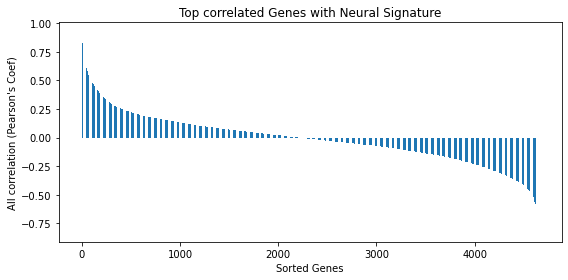

In [16]:
plt.figure(None, (8, 4))
plt.bar(x=range(0, len(corr_list_neural)), height=corr_list_neural.head(len(corr_list_neural))[1], width=0.5)
plt.title("Top correlated Genes with Neural Signature")
plt.xlabel("Sorted Genes")
plt.ylabel("All correlation (Pearson's Coef)")
plt.tight_layout()
plt.show()

In [17]:
len(corr_list_neural)

4652

In [18]:
corr_list_neural.loc["NCAM1"]

1   -0.561165
Name: NCAM1, dtype: float64

In [19]:
D30_filt = copy.deepcopy(vlm)
D30_filt.filter_cells(bool_array=np.array([i in ['D30:EarlyRPE1', 'D30:EarlyRPE2', 'D30:MidRPE1',
                                                 'D30:MidRPE2', 'D30:LateRPE', 
                                                 'D30:RetProg3'] for i in D30_filt.ca["CellTypeCategory2"]]))

In [20]:
D30_filt._normalize_S(relative_size=D30_filt.initial_cell_size,
                      target_size=np.mean(D30_filt.initial_cell_size))

D30_filt._normalize_U(relative_size=D30_filt.initial_Ucell_size,
                      target_size=np.mean(D30_filt.initial_Ucell_size))

D30_filt.perform_PCA()

df30 = pd.DataFrame(D30_filt.S_norm)
df30.columns = D30_filt.ca["CellID"]
df30.index = D30_filt.ra["Gene"]

df30S = pd.DataFrame(D30_filt.S_norm)
df30S.columns = D30_filt.ca["CellID"]
df30S.index = D30_filt.ra["Gene"]

df30U = pd.DataFrame(D30_filt.U_norm)
df30U.columns = D30_filt.ca["CellID"]
df30U.index = D30_filt.ra["Gene"]

In [21]:
RPE_sig_genes = ["BEST1", "ELN", "IGFBP5", "MITF", "PMEL", "RGR",
                 "RLBP1", "RPE65", "SERPINF1", "SLC7A8", "TMEFF2", 
                 "TRPM1", "TRPM3", "TTR", "TYR", "TYRP1"]

In [22]:
df = df30S.loc[RPE_sig_genes].T
df = (df-df.min())/(df.max()-df.min())
df = df.T

rpe_gene_means = np.array(df.mean(0))

corr_list_rpe = {k:None for k in df30S.index}
for i,r in df30S.iterrows():
    if np.mean(r) < 0.5:
        corr_list_rpe[i]= 0
    else:
        counts = list(r)
        corr_list_rpe[i] = np.corrcoef(df30S.loc[i], rpe_gene_means)[0, 1]

In [23]:
corr_list_rpe = pd.DataFrame(corr_list_rpe.items())
corr_list_rpe.set_index(0, inplace=True)
corr_list_rpe.sort_values(1, ascending=False, inplace=True)
corr_list_rpe = corr_list_rpe[corr_list_rpe[1]!=0]

In [24]:
corr_list_rpe = corr_list_rpe[~corr_list_rpe.index.isin(RPE_sig_genes)]

In [25]:
corr_list_rpe.head(25)

,1
0,
TSPAN10,0.845587
DCT,0.842034
APOE,0.781621
GSTP1,0.781484
APOC1,0.753224
GPR143,0.732418
CTSH,0.729625
GNG11,0.707988
ATP1B1,0.703754


In [26]:
corr_list_rpe.tail(20)

,1
0,
DACH1,-0.422209
SELENOP,-0.446712
ALDH1A1,-0.451501
PTMA,-0.455414
NCAM1,-0.457120
SIX3,-0.458977
CPE,-0.466412
TGFB2,-0.471332
NR2F1,-0.478010


In [27]:
len(corr_list_rpe)

4851

In [28]:
# position of NCAM1
len(corr_list_rpe)-np.where(np.array(corr_list_rpe.index=="NCAM1"))[0][0]

16

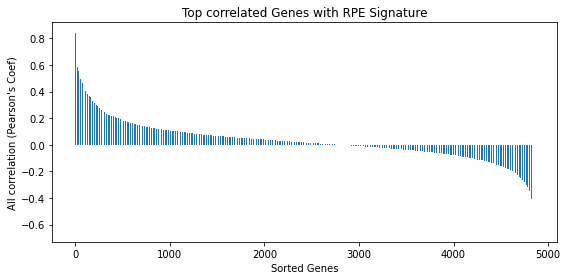

In [29]:
plt.figure(None, (8, 4))
plt.bar(x=range(0, len(corr_list_rpe)), height=corr_list_rpe.head(len(corr_list_rpe))[1], width=0.5)
plt.title("Top correlated Genes with RPE Signature")
plt.xlabel("Sorted Genes")
plt.ylabel("All correlation (Pearson's Coef)")
plt.tight_layout()
plt.show()

In [30]:
combined_df = pd.merge(left=corr_list_rpe, right=corr_list_neural, right_index=True, left_index=True, how="inner")

In [31]:
# top anticorrelated
np.mean(combined_df, axis=1).sort_values().head(20)

0
SFRP2     -0.731883
MARCKS    -0.691738
CRABP1    -0.659508
NR2F1     -0.637261
RAX       -0.621751
CDH2      -0.611774
CPAMD8    -0.580578
MEST      -0.575116
SIX6      -0.568949
RAB31     -0.566752
DACH1     -0.553042
TMSB15A   -0.552663
COL2A1    -0.533734
MAB21L1   -0.530335
NAP1L1    -0.523088
DAPL1     -0.522136
TUBA1B    -0.519299
CENPV     -0.514487
NCAM1     -0.509143
PKDCC     -0.488252
dtype: float64

In [32]:
# top correlated
np.mean(combined_df, axis=1).sort_values().tail(20)

0
SH3BP5     0.447943
S100A11    0.453707
ATP1B1     0.462019
PERP       0.462936
SLC3A2     0.474278
ITGAV      0.487447
GSTP1      0.488418
GSN        0.496995
SPARC      0.507732
OSBPL1A    0.515013
CTSV       0.528249
APP        0.543228
HTRA1      0.545491
APOE       0.573551
CTSH       0.577900
CRYAB      0.579826
SPATS2L    0.626606
GPNMB      0.629784
CXCL14     0.677878
IGFBP7     0.683952
dtype: float64

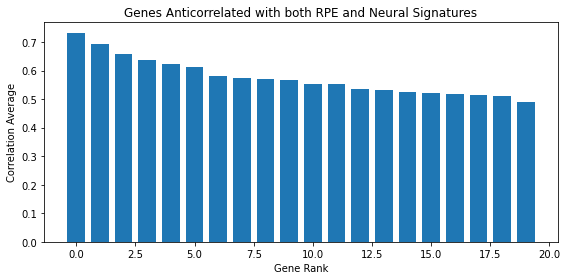

In [33]:
plt.figure(None, (8, 4))
plt.bar(x=range(0, 20), height=-1*np.mean(combined_df, axis=1).sort_values().head(20), width=0.75)
plt.title("Genes Anticorrelated with both RPE and Neural Signatures")
plt.xlabel("Gene Rank")
plt.ylabel("Correlation Average")
plt.tight_layout()
plt.show()

In [34]:
corr_list_rpe

,1
0,
TSPAN10,0.845587
DCT,0.842034
APOE,0.781621
GSTP1,0.781484
APOC1,0.753224
...,...
TMSB4X,-0.567210
IGFBP2,-0.576539
DKK3,-0.579963


In [35]:
corr_list_neural

,1
0,
CCDC3,0.919493
CXCL14,0.884650
S100A10,0.883879
SPINT1,0.876650
S100A11,0.869783
...,...
NR2F1,-0.796513
SFRP2,-0.810097
MARCKS,-0.820441
